# Comparing CATE-BLP to Plugin Interactive Linear Model 

In [182]:
# Setup
remotes::install_github("christophergandrud/blpopt")
remotes::install_github("christophergandrud/drlearner")

xfun::pkg_attach2("blpopt", "drlearner", "grf", "tidyr", "dplyr", "ggplot2")

theme_set(theme_minimal())

Skipping install of 'blpopt' from a github remote, the SHA1 (38cf49c0) has not changed since last install.
  Use `force = TRUE` to force installation

Skipping install of 'drlearner' from a github remote, the SHA1 (a856d84f) has not changed since last install.
  Use `force = TRUE` to force installation



## Compare with 1 simulation

In [167]:
# Simulate data
set.seed(3214)
n <- 2000
p <- 20
X <- matrix(rnorm(n * p), n, p)

# CATE varies along one dim only.
tau_ex <- function(x) {
  1 / (1 + exp(-x))
}
TAU <- tau_ex(X[, 3])

# Propensity  and Outcome vary along 2 and 5 dimensions only.
W <- rbinom(n, 1, 1 / (1 + exp(-X[, 1] - X[, 2])))
Y <- pmax(X[, 2] + X[, 3], 0) + rowMeans(X[, 4:6]) / 2 + W * TAU + rnorm(n)

In [168]:
# Predict from plugin naive interactive linear model
lm_fitted <- lm(Y ~ X[,c(1:2, 4:p)] + W * TAU)

lm_pred <- data.frame(lm_predicted =
                          (lm_fitted$coefficients["W"] +
                               lm_fitted$coefficients["TAU"] * TAU +
                               (lm_fitted$coefficients["W:TAU"] * TAU)) -
                          lm_fitted$coefficients["TAU"] * TAU)

In [169]:
# CATE-BLP with Causal Forest
cf <- causal_forest(X, Y, W)
blp_cf <- cate_blp(cf, X[, 3])
blp_cf_pred <- predict(blp_cf)

In [170]:
# CATE-BLP with DR Learner (Kennedy 2022)
drl <- dr_learner(X, Y, W)
blp_drl <- cate_blp(drl, X[, 3])
blp_drl_pred <- tibble(blp_drl = predict(blp_drl)$predicted)

In [171]:
# Combine into one data frame
comb_df <- cbind(blp_cf_pred, blp_drl_pred, lm_pred) %>%
    pivot_longer(cols = 2:4, names_to = "type",
    values_to = "prediction")
comb_df$type <- factor(comb_df$type, 
                        levels = c("lm_predicted", "predicted", "blp_drl"),
                        labels = c("Plugin LM", "CATE-BLP (Causal Forest)", "CATE-BLP (DR Learner)"))


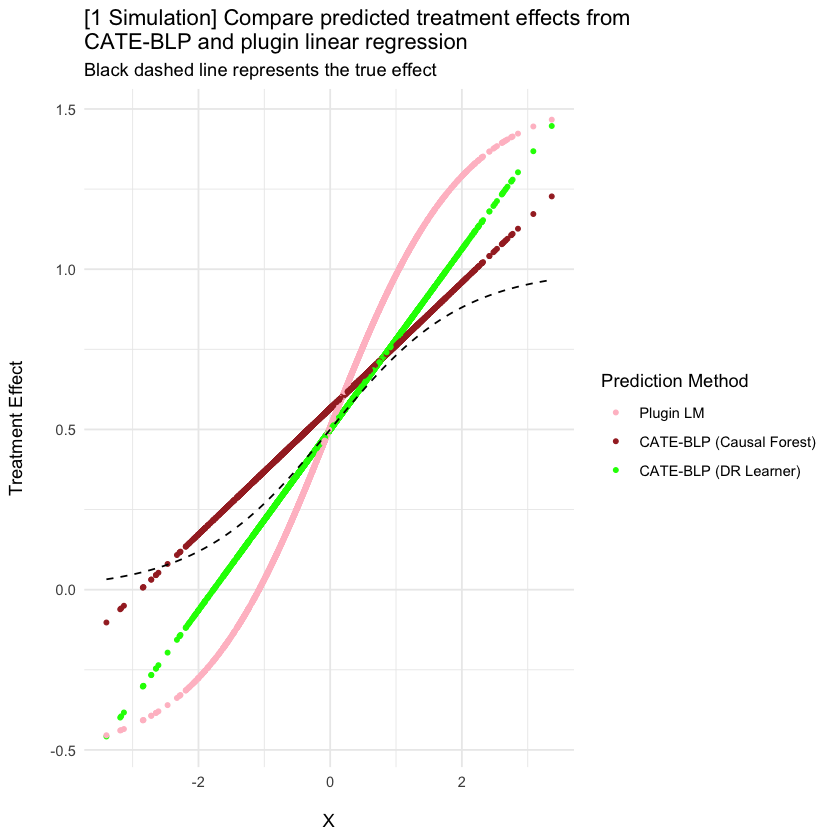

In [183]:
# Visually compare predictions
ggplot(comb_df, aes(x = A, y = prediction, color = type)) +
  geom_point(size = 1) +
  geom_function(fun = tau_ex, col = "black", linetype = "dashed") +
  scale_color_manual(values = c("pink", "brown", "green"), name = "Prediction Method") +
  xlab("\nX") + ylab("Treatment Effect\n") +
  ggtitle("[1 Simulation] Compare predicted treatment effects from\nCATE-BLP and plugin linear regression ",
    subtitle = "Black dashed line represents the true effect")

## Compare using hundreds of simulations

In [173]:
nsim = 300
n = 2000

results_mse <- data.frame(matrix(nrow = nsim, ncol = 3))
colnames(results_mse) <- c("plugin", "drl", "cf")

for (i in 1:nsim) {
  # Simulate data
  p <- 20
  X <- matrix(rnorm(n * p), n, p)

  # CATE varies along one dim only.
  tau_ex <- function(x) {
    1 / (1 + exp(-x))
  }
  TAU <- tau_ex(X[, 3])

  # Propensity  and Outcome vary along 2 and 5 dimensions only.
  W <- rbinom(n, 1, 1 / (1 + exp(-X[, 1] - X[, 2])))
  Y <- pmax(X[, 2] + X[, 3], 0) + rowMeans(X[, 4:6]) / 2 + W * TAU + rnorm(n)

  # Predict from simple lm
  lm_fitted <- lm(Y ~ X[,c(1:2, 4:p)] + W * TAU)

  lm_pred <- data.frame(lm_predicted =
                            (lm_fitted$coefficients["W"] +
                                lm_fitted$coefficients["TAU"] * TAU +
                                (lm_fitted$coefficients["W:TAU"] * TAU)) -
                            lm_fitted$coefficients["TAU"] * TAU)

  # CATE-BLP
  cf <- causal_forest(X, Y, W)
  blp_cf <- cate_blp(cf, X[, 3])
  blp_cf_pred <- predict(blp_cf)

  drl <- dr_learner(X, Y, W)
  blp_drl <- cate_blp(drl, X[, 3])
  blp_drl_pred <- predict(blp_drl)

  results_mse$plugin[i] <- mean((lm_pred$lm_predicted - TAU)^2)
  results_mse$drl[i] <- mean((blp_drl_pred$predicted - TAU)^2)
  results_mse$cf[i] <- mean((blp_cf_pred$predicted - TAU)^2)
}

In [177]:
summary(results_mse)

     plugin              drl                  cf           
 Min.   :0.007904   Min.   :0.0007164   Min.   :0.0006274  
 1st Qu.:0.036124   1st Qu.:0.0029921   1st Qu.:0.0030236  
 Median :0.050053   Median :0.0070236   Median :0.0060719  
 Mean   :0.052875   Mean   :0.0112291   Mean   :0.0087057  
 3rd Qu.:0.064547   3rd Qu.:0.0147229   3rd Qu.:0.0119324  
 Max.   :0.135469   Max.   :0.1367045   Max.   :0.0443504  

In [178]:
df_mse <- pivot_longer(results_mse, cols = 1:3)
df_mse$name <- factor(df_mse$name, 
                        levels = c("plugin", "cf", "drl"),
                        labels = c("Plugin LM", "CATE-BLP (Causal Forest)", "CATE-BLP (DR Learner)"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


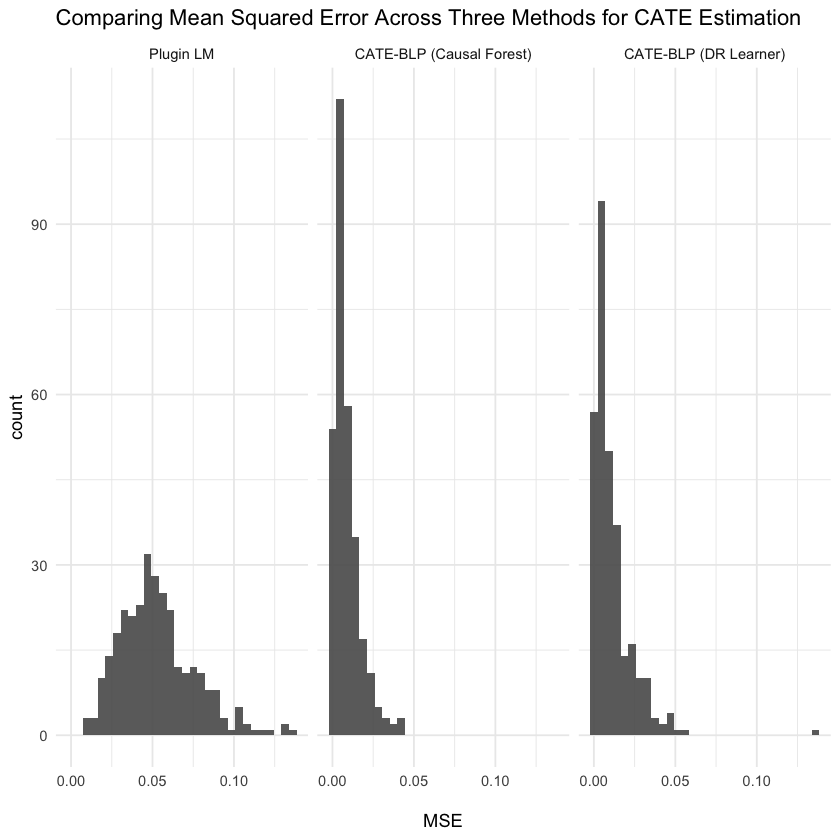

In [181]:
ggplot(df_mse, aes(value)) +
    facet_grid(.~name) +
    geom_histogram(alpha = 0.9) +
    xlab("\nMSE") +
    ggtitle("Comparing Mean Squared Error Across Three Methods for CATE Estimation")